<h4 align="right"> Felix Filipi</h4>
<h5 align='right'>2301877590</h5>
<h1 align="center"> Computer Vision Documentation</h1>
<h2 align="center">Canny Edge Detection from scratch</h2>

# Import Library

We'll try to code the canny from scratch without opencv at all. Perhaps we will use it later as a comparison only.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load Image

We can create a function to call the image easier.

In [2]:
def load_img(img):
    loaded_img = np.array(Image.open(img))
    return loaded_img

# 5 steps of Canny Detection:
* Noise reduction;
* Gradient calculation;
* Non-maximum suppression;
* Double threshold;
* Edge Tracking by Hysteresis.

# Noise Reduction

<b> Before we do Noise Reduction using gaussian blur from scratch, we should preprocess it to become grayscale image. To do this, we can use grayscale converter from scratch using this formula:</b>
    
$$ Gray = 0.2989 \times R + 0.5870 * G + 0.1140 * B $$

In [3]:
def grayscale(img):
    r, g, b = img[:,:,0], img[:,:,1], img[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray

Now we go into the topic.

Edge Detection highly sensitive to image noise. That's why we should preprocess the image by removing this noise using blur kernel to smooth it. Usually Canny detection use gaussian blue as its preprocessing method.

The equation for a Gaussian filter kernel of size (2k+1)×(2k+1) is given by:

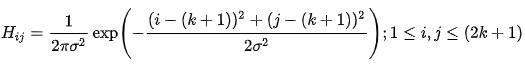

The role of sigma in the Gaussian filter is to control the variation around its mean value. So as the Sigma becomes larger the more variance allowed around mean and as the Sigma becomes smaller the less variance allowed around mean.

<h3>And here's the code for gaussian blur from scratch:</h3>

In [4]:
def gauss_blur(image, ksize, sigma = 1): #set default sigma 1
        
    #This formula can be seen from above explanation
    normalization = 1 / (2 * np.pi * sigma**2)
    
    #split mgrid to make sure kernel have its true size
    ksize = round(ksize//2) 
    
    #generate 2D kernel with different direction (i horizontal, j vertical) between kernel size 
    #The i variable for (i-(k+1)) and j variable for (j-(k+1)) 
    i, j = np.mgrid[-ksize:ksize+1, -ksize:ksize+1] 

    #Generated gaussian kernel from formula
    kernel =  normalization * np.exp(-((i**2 + j**2) / (2*sigma**2))).flatten() #flatten to convolve

    #Convolve the kernel to image
    image = image.flatten()
    res = np.convolve(image,kernel,"same") #np.convolve works in 1D arr
    res = np.reshape(res,(gray.shape)) #return as its true 2D arr to visualize it
    return res

<h3>In order to make visualization more easier, we can define it as.

In [5]:
def visualize(img_list,title_list):
    plt.figure(figsize=(16,16))
    for i in range(len(img_list)):
        plt.subplot(3,3,i+1)
        plt.imshow(img_list[i], cmap = 'gray')
        plt.xticks([]),plt.yticks([])
        plt.title(title_list[i])

<h3>Now, all function has been created, let's try to call the function.

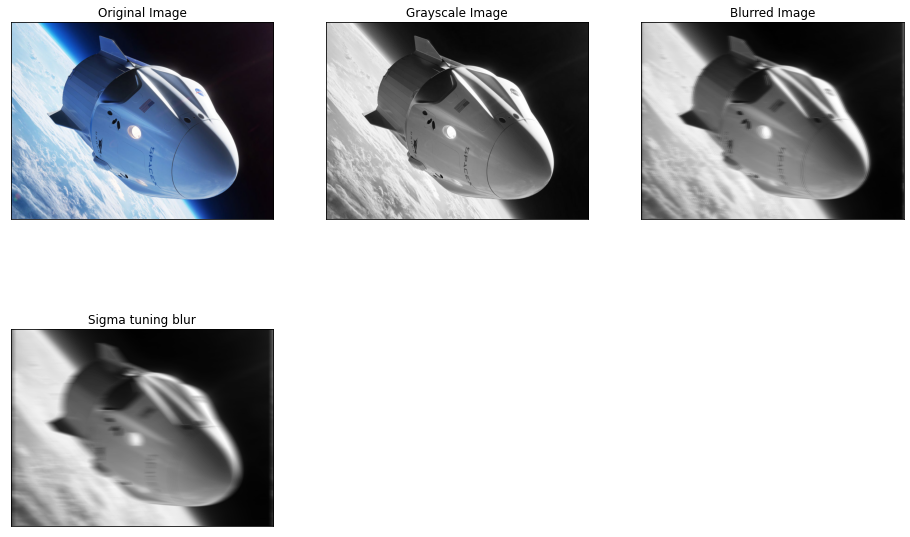

In [6]:
img = load_img('dataset.jpg')
gray = grayscale(img)
blur_img = gauss_blur(gray,7) #default sigma 1
sigma_blur_img = gauss_blur(gray, 7, sigma = 3) #try sigma in 3. Higher sigma, means higher blur

img_list = [img,gray,blur_img,sigma_blur_img]
title_list = ['Original Image', 'Grayscale Image', 'Blurred Image','Sigma tuning blur']
visualize(img_list,title_list)

<h3> Now we have done the Noise Reduction step, now let's go deeper into the next phase which is Gradient Calculation

# Gradient Calculation

The Gradient calculation step detects the edge intensity and direction by calculating the gradient of the image using edge detection operators. The easiest way to detect the edge is by applying a filter that changes both directions x and y. So, it can be done by convolving it using Sobel kernels. Here's what's the mean of Sobel's kernel:

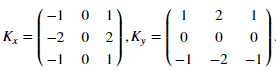

Later, after the image already convolved by each kernel, then we should apply magnitude $(G)$ and slope $\theta$ of the gradient, which calculated as follow:

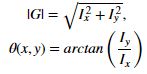

So, now we know the theory of this gradient calculation. Let's go deeper into the code implementation

In [7]:
def sobel_edge_detection(img):
    
    #Define the sobel_kernel
    X_kernel = np.array(
        [-1,0,1,
         -2,0,2,
         -1,0,1]) #plot in 1D, because we are going to use np.convolve
    
    Y_kernel = np.array(
        [1,2,1,
         0,0,0,
         -1,-2,-1]) #plot in 1D, because we are going to use np.convolve
    
    #convert image to 1D before convolve
    img_flatten = img.flatten()
    #Convolve each direction
    X_convolve = np.convolve(img_flatten,X_kernel,"same")
    Y_convolve = np.convolve(img_flatten,Y_kernel,"same")
    
    #After each convolve done, we need to apply hypotenuse sqrt(x**2 + y**2)
    #Numpy provide the build in function which is np.hypot, but let's try to do it from scratch
    hypotenuse = np.sqrt(X_convolve**2 + Y_convolve**2)
    sobel_res = np.abs(hypotenuse) #the formula describe the absolute function in its formula
    sobel_res = np.reshape(hypotenuse,img.shape) #back to 2D form to visualize it
    
    #Go into next formula, slope of the gradient
    slope = np.arctan2(X_convolve,Y_convolve)
    slope = np.reshape(slope,img.shape)
    
    return sobel_res, slope

<h3> Now we have done creating the function. Let's try to call it. </h3>

In this phase, I will try to figure out what will happen if we didn't use noise reduction in our gradient calculation.

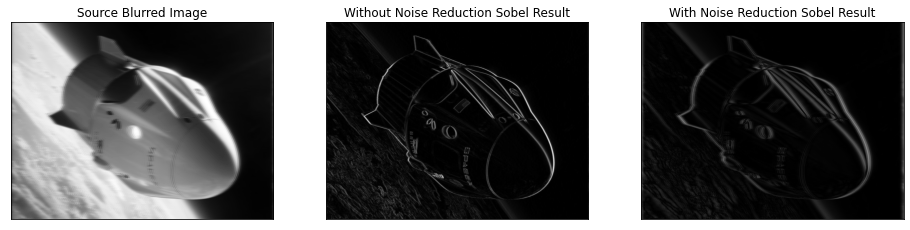

In [8]:
#let's try to plot it without Noise Reduction
gray_gradient_calculated, t = sobel_edge_detection(gray) 

gradient_calculated, slope = sobel_edge_detection(blur_img)

img_list = [blur_img, gray_gradient_calculated, gradient_calculated]
img_title = ['Source Blurred Image','Without Noise Reduction Sobel Result','With Noise Reduction Sobel Result']

visualize(img_list,img_title)

We can see here, that noise reduction plays a crucial role in order to generate better edge detection, so keep it in mind to use noise reduction in edge detection.

<h3> Now we have done the Gradient Calculation step, now let's go to the next phase which is Non-Maximum Suppression

The edge detection image should have thin edges, we don't need a lot of strike inside an edge to be seen. Thus, we must perform non-maximum suppression to thin out the edges.

So how do non-maximum suppression works? This algorithm goes through all the points on the edge and finds the pixels with the maximum value in the edge directions.

So simply this algorithm work like this:
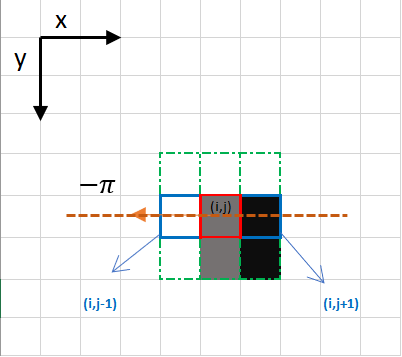

<b>The algorithm's purpose is to check if the pixels on the same direction are more or less intense than the one being processed.</b>

In the example above, the pixel (i, j) is being processed, and the pixels on the same direction are highlighted in blue (i, j-1) and (i, j+1). If one those two pixels are more intense than the one being processed, then only the more intense one is kept. Pixel (i, j-1) seems to be more intense, because it is white (value of 255). Hence, the intensity value of the current pixel (i, j) is set to 0. If there are no pixels in the edge direction having more intense values, then the value of the current pixel is kept.

So, this algorithm works as a threshold too, but its threshold depends on its own neighbors. For example, the gray pixel here will be set to be 0 because there's a higher intensity which is a white pixel on its left. And this will be worked until the pixel left only the black (i,j+1) pixel.

So, as summary, here's how to do non-max suppresion:

* Create a matrix initialized to 0 of the same size of the original gradient intensity matrix;
* Identify the edge direction based on the angle value from the angle matrix;
* Check if the pixel in the same direction has a higher intensity than the pixel that is currently processed;
* Return the image processed with the non-max suppression algorithm.

In [9]:
def non_max_suppression(img,theta):
    height = img.shape[0]
    width = img.shape[1]
    
    #Create matrix init to 0 of the same size of the original img.
    non_max = np.zeros((height,width))
    
    
    #Identify the edge direction based on the angle.
    
    
    #Convert from radians to degrees by multiplying the number of radians by 180/pi.
    #theta = radians
    angle = theta * (180 / np.pi) 
     
    #This returns the degree between -180 to 180
    #which we will convert from 0 to 360 by adding 180 to gradient_direction
    angle[angle < 0] += 180
    
    #Check if the pixel in the same direction has a higher intensity than currently processed pixel.
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            PI = 180
            direction = angle[i,j]
            
            # 0 to 22.5 (PI / 8)
            if (0 <= direction < PI / 8) or (15 * PI / 8 <= direction <= 2 * PI):
                before_pixel = img[i, j - 1]
                after_pixel = img[i, j + 1]
            
            #22.5 to 67.5 (3* PI / 8)
            elif (PI / 8 <= direction < 3 * PI / 8) or (9 * PI / 8 <= direction < 11 * PI / 8):
                before_pixel = img[i + 1, j - 1]
                after_pixel = img[i - 1, j + 1]
                
            #67.5 to 112.5 (5 * PI / 8)
            elif (3 * PI / 8 <= direction < 5 * PI / 8) or (11 * PI / 8 <= direction < 13 * PI / 8):
                before_pixel = img[i - 1, j]
                after_pixel = img[i + 1, j]
                
            #112.5 to 157.5 (7 * PI / 8)
            else:
                before_pixel = img[i - 1, j - 1]
                after_pixel = img[i + 1, j + 1]
                
            #check direction then append to value    
            if(img[i,j] >= before_pixel) and (img[i,j] >= after_pixel):
                non_max[i,j] = img[i,j]
            else:
                non_max[i,j] = 0
                
    return non_max

<h3> Now we have done creating the function. Let's try to call it. </h3>

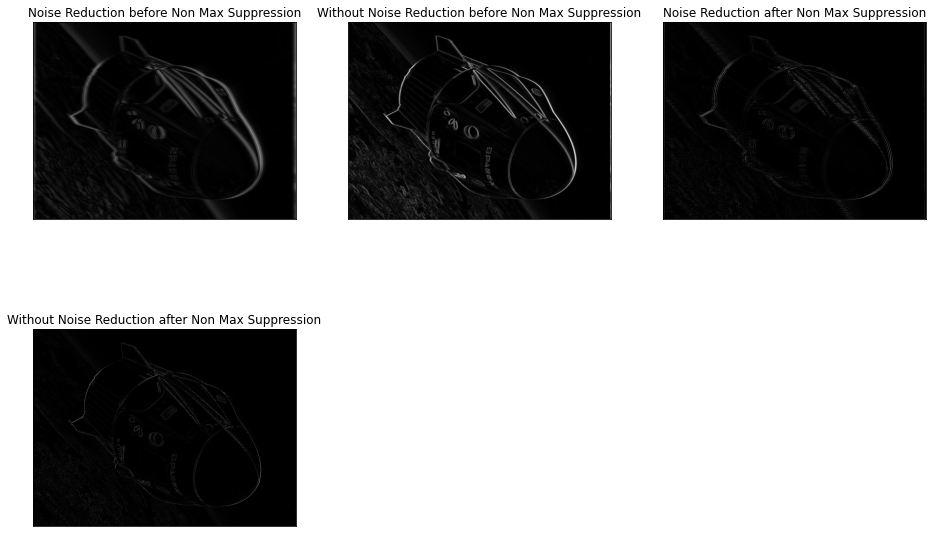

In [10]:
noise_reduction_nms = non_max_suppression(gradient_calculated, slope)
no_reduction_nms = non_max_suppression(gray_gradient_calculated, t)

nms_list = [gradient_calculated, gray_gradient_calculated, noise_reduction_nms, no_reduction_nms]
nms_title = ['Noise Reduction before Non Max Suppression',
            'Without Noise Reduction before Non Max Suppression',
            'Noise Reduction after Non Max Suppression',
            'Without Noise Reduction after Non Max Suppression']

visualize(nms_list,nms_title)

The result is the same image with thinner edges. However as we can see, some pixels seems to be brighter than others, and we will try solve it in the next two final steps.

<h3> We have done the Non-Maximum Suppression step, now let's go to the next phase which is Double Threshold

The double threshold aims to identify 3 kinds of pixels which is strong, weak, and non-relevant. And double threshold itself stand for High threshold and low threshold. Here's the explanation:

* Strong pixels are pixels that have high intensity which will contribute to the final edge. This strong pixels will be identified by high threshold, when the value higher than the threshold it can be classified as strong pixels
* Weak pixels are pixels that have an intensity value that is not enough to be considered as strong ones, but yet not small enough to be considered as non-relevant for the edge detection. This weak pixels will be identified by low threshold, when the value lower than the threshold, then it can be classified as weak pixels
* Other pixels are considered as non-relevant for the edge.

<b>So, now we have know about the theory, now let's jump into the code.</b>

In [11]:
def default_threshold(img):
    high_threshold = img.max() * 0.09
    low_threshold = high_threshold * 0.05
    return high_threshold, low_threshold
    
def double_threshold(img, threshold = default_threshold(img)): #define default
    
    #define high and low threshold
    high_threshold = threshold[0]
    low_threshold = threshold[1]
    
    height = img.shape[0]
    width = img.shape[1]
    
    #Create matrix init to 0 of the same size of the original img.
    double_thresholded = np.zeros((height, width))
    
    #strong pixels means higher than its high threshold
    strong_height, strong_width = np.where(img >= high_threshold)
    
    #weak pixels means lower than higher threshold but higher than its minimum threshold
    weak_height, weak_width = np.where((img< high_threshold) & (img >= low_threshold))
    
    #other means useless,not related pixel
    other_height, other_width = np.where(img < low_threshold)
    
    double_thresholded[strong_height, strong_width] = 255 #higher than threshold set 255
    double_thresholded[weak_height, weak_width] = 50 #weak values set as 20
    
    return double_thresholded

<h3> Now we have done creating the function. Let's try to call it. </h3>

We will try to implement each case with 2 condition default threshold, and custom threshold

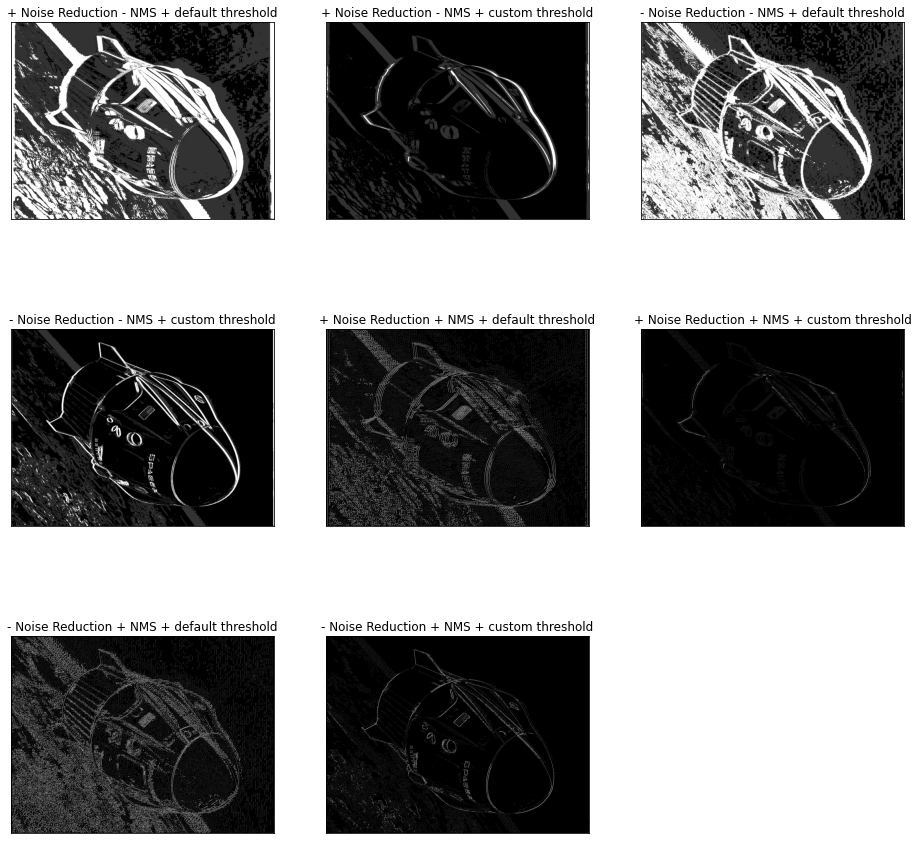

In [12]:
thresholded = []
thresholded_title = ['+ Noise Reduction - NMS + default threshold',
                     '+ Noise Reduction - NMS + custom threshold',
                     '- Noise Reduction - NMS + default threshold',
                     '- Noise Reduction - NMS + custom threshold',
                     '+ Noise Reduction + NMS + default threshold',
                     '+ Noise Reduction + NMS + custom threshold',
                     '- Noise Reduction + NMS + default threshold',
                     '- Noise Reduction + NMS + custom threshold']

for i in range(len(nms_list)):
    
    #let's try the default double threshold value
    double_thresholded = double_threshold(nms_list[i])
    thresholded.append(double_thresholded)
    
    #now implement the custom high and low threshold
    double_thresholded_custom = double_threshold(nms_list[i], (200,40)) #200 high, 20 low
    thresholded.append(double_thresholded_custom)
    
visualize(thresholded, thresholded_title)

<b>As we can see here from the result, each case has its own power, but the best case from all plotted image here still gained from + noise reduction, + Non Maximum Suppression + default threshold. But perhaps, if we tune the custom threshold parameter more carefully, we can able to generate the better result</b>

<h3> So much step has been done, and now it's going to be the end. This is the last step needed to generate canny edge detection. Edge Tracking by Hysteresis

So, what does this step means to do? the Hysteresis mechanism aims to help us to determine which ones that could be considered as strong and the ones that are considered as non-relevant from weak pixel.

Based on the threshold results, the hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one, as described below:
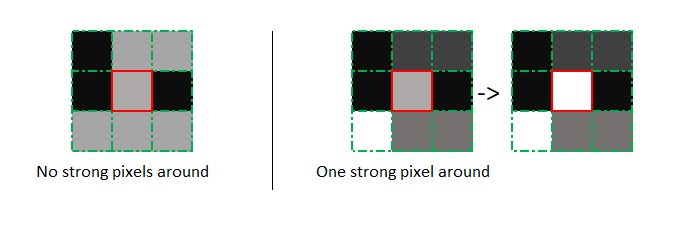

Let's jump to the last function!!!!

In [13]:
def hysteresis(img, weak = 50, strong = 255):
    height = img.shape[0]
    width = img.shape[1]
    
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            if(img[i,j] == weak):
                if ((img[i+1, j-1] == strong) 
                    or (img[i+1, j] == strong) 
                    or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) 
                    or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) 
                    or (img[i-1, j] == strong) 
                    or (img[i-1, j+1] == strong)): #try each direction of pixel
                    
                    img[i,j] = strong
                else:
                    img[i,j] = 0
    return img

<h3> Now we have done creating the function. Let's try to call it. </h3>

We will try to implement each case before with hysteresis to generate its final result

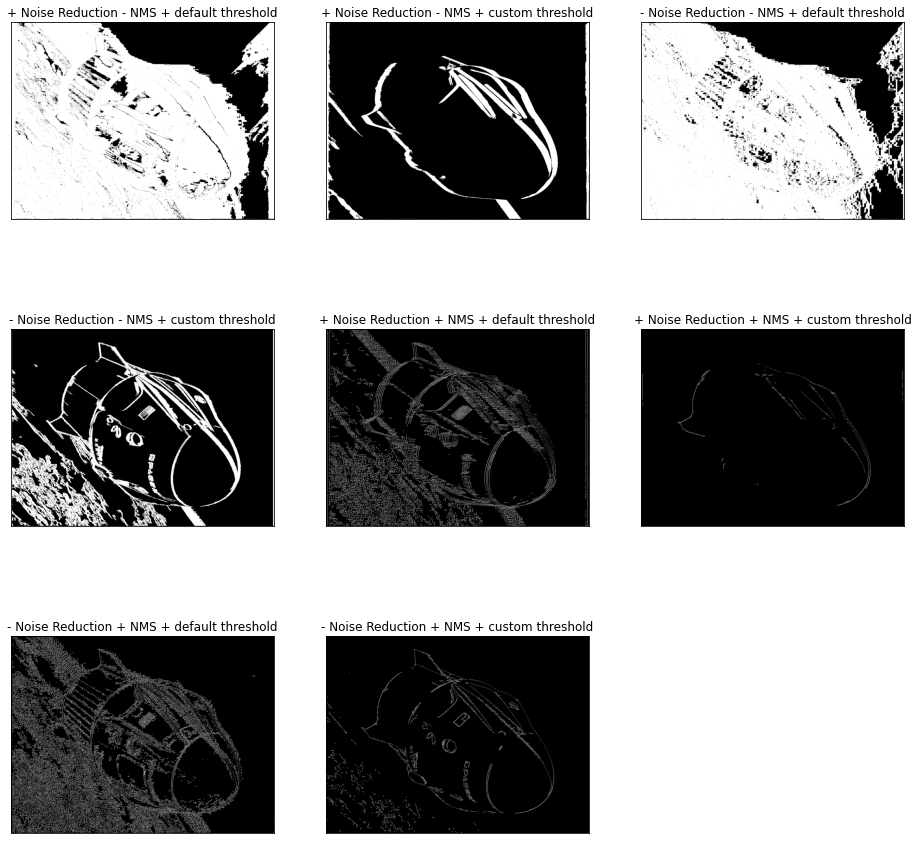

In [14]:
result = []
for i in range(len(thresholded)):
    res = hysteresis(thresholded[i])
    result.append(res)
    
result_title = ['+ Noise Reduction - NMS + default threshold',
                 '+ Noise Reduction - NMS + custom threshold',
                 '- Noise Reduction - NMS + default threshold',
                 '- Noise Reduction - NMS + custom threshold',
                 '+ Noise Reduction + NMS + default threshold',
                 '+ Noise Reduction + NMS + custom threshold',
                 '- Noise Reduction + NMS + default threshold',
                 '- Noise Reduction + NMS + custom threshold']

visualize(result, result_title)

# Now we can see that the result is different each other, in this case the best tuning is not by implementing noise reduction with custom threshold and without non maximum suppression, but this case is different each other depends on the picture itself

Now, let's try compare this result by using canny from OpenCV

(([], []), ([], []))

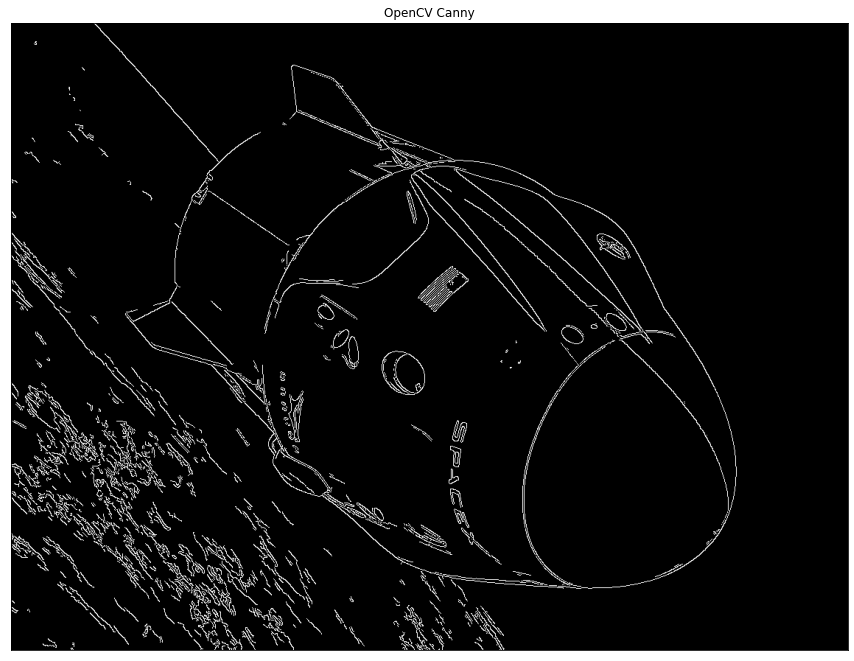

In [15]:
import cv2

gray = np.uint8(gray)
canny = cv2.Canny(gray, 100,200)
title = 'OpenCV Canny'
plt.figure(figsize=(15,15))
plt.imshow(canny, cmap='gray')
plt.title(title)
plt.xticks([]), plt.yticks([])

<h3> Yes, it's giving almost the same result as our algorithm from scratch result.</h3>

<h1> So that's the end of my research, I'm trying to tweaking the canny algorithm, but still can't find the better method to return best canny edge detection. Thanks for watching